In [ ]:
!pip install tensorflow

In [ ]:
# The following code is only required if you intend to store the model and input train/test files on the Google Drive. It mounts the Google Drive onto the running instance.
# If you're uploading files during runtime, you can comment out this code.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Config and Hyperparameters

In [ ]:
# Configuration parameters for data preprocessing
config_preprocessing = {
    "data_dir": "/content/drive/MyDrive/Colab Notebooks",                             # Directory containing input data files
    "embeddings_file": "/content/drive/MyDrive/Colab Notebooks/glove.840B.300d.txt",  # Path to pre-trained word embeddings file from Stanford obtained from  * https://nlp.stanford.edu/projects/glove/
    "target_dir": "./SNLI/",                                                          # Target directory for preprocessed output files
    "lowercase": False,                                                               # Flag to indicate whether to convert words to lowercase
    "ignore_punctuation": False,                                                      # Flag to indicate whether to ignore punctuation
    "num_words": None,                                                                # Number of words to include in vocabulary
    "stopwords": [],                                                                  # List of stopwords to be ignored during preprocessing.
    "labeldict": {"entailment": 1, "contradiction": 0},                               # Mapping of labels to numerical values
    "bos": "_BOS_",                                                                   # Beginning of sentence token
    "eos": "_EOS_"                                                                    # End of sentence token
}

# Configuration parameters for model training
config_training = {
    "train_data": "./SNLI/train_data.pkl",   # Path to preprocessed training data
    "valid_data": "./SNLI/dev_data.pkl",     # Path to preprocessed validation data
    "embeddings": "./SNLI/embeddings.pkl",   # Path to preprocessed word embeddings produced during the preprocessing phase
    "target_dir": "./SNLITrain/",            # Target directory for output files during training
    "hidden_size": 300,    # Size of hidden layer in the model
    "dropout": 0.5,        # Dropout probability
    "num_classes": 2,      # Number of output classes
    "epochs": 64,          # Number of training epochs
    "batch_size": 32,      # Batch size for training
    "lr": 0.0004,          # Learning rate
    "patience": 5,         # Patience for early stopping
    "max_gradient_norm": 10.0    # Maximum gradient norm for gradient clipping
}

# Defining the Model and Helper Functions

## Helper Util Functions Define

In [ ]:
import torch
import torch.nn as nn

def sort_by_seq_lens(batch, sequences_lengths, descending=True):
    """
    Sort a batch of padded variable length sequences by their length.

    Args:
        batch: A batch of padded variable length sequences. The batch should
            have the dimensions (batch_size x max_sequence_length x *).
        sequences_lengths: A tensor containing the lengths of the sequences in the
            input batch. The tensor should be of size (batch_size).
        descending: A boolean value indicating whether to sort the sequences
            by their lengths in descending order. Defaults to True.

    Returns:
        sorted_batch: A tensor containing the input batch reordered by
            sequences lengths.
        sorted_seq_lens: A tensor containing the sorted lengths of the
            sequences in the input batch.
        sorting_idx: A tensor containing the indices used to permute the input
            batch in order to get 'sorted_batch'.
        restoration_idx: A tensor containing the indices that can be used to
            restore the order of the sequences in 'sorted_batch' so that it
            matches the input batch.
    """
    sorted_seq_lens, sorting_index =\
        sequences_lengths.sort(0, descending=descending)

    sorted_batch = batch.index_select(0, sorting_index)

    idx_range =\
        sequences_lengths.new_tensor(torch.arange(0, len(sequences_lengths)))
    _, reverse_mapping = sorting_index.sort(0, descending=False)
    restoration_index = idx_range.index_select(0, reverse_mapping)

    return sorted_batch, sorted_seq_lens, sorting_index, restoration_index


def get_mask(sequences_batch, sequences_lengths):
    """
    Get the mask for a batch of padded variable length sequences.

    Args:
        sequences_batch: A batch of padded variable length sequences
            containing word indices. Must be a 2-dimensional tensor of size
            (batch, sequence).
        sequences_lengths: A tensor containing the lengths of the sequences in
            'sequences_batch'. Must be of size (batch).

    Returns:
        A mask of size (batch, max_sequence_length), where max_sequence_length
        is the length of the longest sequence in the batch.
    """
    batch_size = sequences_batch.size()[0]
    max_length = torch.max(sequences_lengths)
    mask = torch.ones(batch_size, max_length, dtype=torch.float)
    mask[sequences_batch[:, :max_length] == 0] = 0.0
    return mask

def masked_softmax(tensor, mask):
    """
    Apply a masked softmax on the last dimension of a tensor.
    The input tensor and mask should be of size (batch, *, sequence_length).

    Args:
        tensor: The tensor on which the softmax function must be applied along
            the last dimension.
        mask: A mask of the same size as the tensor with 0s in the positions of
            the values that must be masked and 1s everywhere else.

    Returns:
        A tensor of the same size as the inputs containing the result of the
        softmax.
    """
    tensor_shape = tensor.size()
    reshaped_tensor = tensor.view(-1, tensor_shape[-1])

    # Reshape the mask so it matches the size of the input tensor.
    while mask.dim() < tensor.dim():
        mask = mask.unsqueeze(1)
    mask = mask.expand_as(tensor).contiguous().float()
    reshaped_mask = mask.view(-1, mask.size()[-1])

    result = nn.functional.softmax(reshaped_tensor * reshaped_mask, dim=-1)
    result = result * reshaped_mask
    # 1e-13 is added to avoid divisions by zero.
    result = result / (result.sum(dim=-1, keepdim=True) + 1e-13)

    return result.view(*tensor_shape)

def weighted_sum(tensor, weights, mask):
    """
    Apply a weighted sum on the vectors along the last dimension of 'tensor',
    and mask the vectors in the result with 'mask'.

    Args:
        tensor: A tensor of vectors on which a weighted sum must be applied.
        weights: The weights to use in the weighted sum.
        mask: A mask to apply on the result of the weighted sum.

    Returns:
        A new tensor containing the result of the weighted sum after the mask
        has been applied on it.
    """
    weighted_sum = weights.bmm(tensor)

    while mask.dim() < weighted_sum.dim():
        mask = mask.unsqueeze(1)
    mask = mask.transpose(-1, -2)
    mask = mask.expand_as(weighted_sum).contiguous().float()

    return weighted_sum * mask

def replace_masked(tensor, mask, value):
    """
    Replace the all the values of vectors in 'tensor' that are masked in
    'masked' by 'value'.

    Args:
        tensor: The tensor in which the masked vectors must have their values
            replaced.
        mask: A mask indicating the vectors which must have their values
            replaced.
        value: The value to place in the masked vectors of 'tensor'.

    Returns:
        A new tensor of the same size as 'tensor' where the values of the
        vectors masked in 'mask' were replaced by 'value'.
    """
    mask = mask.unsqueeze(1).transpose(2, 1)
    reverse_mask = 1.0 - mask
    values_to_add = value * reverse_mask
    return tensor * mask + values_to_add


def correct_predictions(output_probabilities, targets):
    """
    Compute the number of predictions that match some target classes in the
    output of a model.

    Args:
        output_probabilities: A tensor of probabilities for different output
            classes.
        targets: The indices of the actual target classes.

    Returns:
        The number of correct predictions in 'output_probabilities'.
    """
    _, out_classes = output_probabilities.max(dim=1)
    correct = (out_classes == targets).sum()
    return correct.item()

## Layers Define

In [ ]:
class RNNDropout(nn.Dropout):
    """
    Dropout layer for the inputs of RNNs.

    Apply the same dropout mask to all the elements of the same sequence in
    a batch of sequences of size (batch, sequences_length, embedding_dim).
    """

    def forward(self, sequences_batch):
        """
        Apply dropout to the input batch of sequences.

        Args:
            sequences_batch: A batch of sequences of vectors that will serve
                as input to an RNN.
                Tensor of size (batch, sequences_length, emebdding_dim).

        Returns:
            A new tensor on which dropout has been applied.
        """
        ones = sequences_batch.data.new_ones(sequences_batch.shape[0],
                                             sequences_batch.shape[-1])
        dropout_mask = nn.functional.dropout(ones, self.p, self.training,
                                             inplace=False)
        return dropout_mask.unsqueeze(1) * sequences_batch


class Seq2SeqEncoder(nn.Module):
    """
    RNN taking variable length padded sequences of vectors as input and
    encoding them into padded sequences of vectors of the same length.

    This module is useful to handle batches of padded sequences of vectors
    that have different lengths and that need to be passed through a RNN.
    The sequences are sorted in descending order of their lengths, packed,
    passed through the RNN, and the resulting sequences are then padded and
    permuted back to the original order of the input sequences.
    """

    def __init__(self,
                 rnn_type,
                 input_size,
                 hidden_size,
                 num_layers=1,
                 bias=True,
                 dropout=0.0,
                 bidirectional=False):
        """
        Args:
            rnn_type: The type of RNN to use as encoder in the module.
                Must be a class inheriting from torch.nn.RNNBase
                (such as torch.nn.LSTM for example).
            input_size: The number of expected features in the input of the
                module.
            hidden_size: The number of features in the hidden state of the RNN
                used as encoder by the module.
            num_layers: The number of recurrent layers in the encoder of the
                module. Defaults to 1.
            bias: If False, the encoder does not use bias weights b_ih and
                b_hh. Defaults to True.
            dropout: If non-zero, introduces a dropout layer on the outputs
                of each layer of the encoder except the last one, with dropout
                probability equal to 'dropout'. Defaults to 0.0.
            bidirectional: If True, the encoder of the module is bidirectional.
                Defaults to False.
        """
        assert issubclass(rnn_type, nn.RNNBase),\
            "rnn_type must be a class inheriting from torch.nn.RNNBase"

        super(Seq2SeqEncoder, self).__init__()

        self.rnn_type = rnn_type
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias = bias
        self.dropout = dropout
        self.bidirectional = bidirectional

        self._encoder = rnn_type(input_size,
                                 hidden_size,
                                 num_layers=num_layers,
                                 bias=bias,
                                 batch_first=True,
                                 dropout=dropout,
                                 bidirectional=bidirectional)

    def forward(self, sequences_batch, sequences_lengths):
        """
        Args:
            sequences_batch: A batch of variable length sequences of vectors.
                The batch is assumed to be of size
                (batch, sequence, vector_dim).
            sequences_lengths: A 1D tensor containing the sizes of the
                sequences in the input batch.

        Returns:
            reordered_outputs: The outputs (hidden states) of the encoder for
                the sequences in the input batch, in the same order.
        """
        sorted_batch, sorted_lengths, _, restoration_idx =\
            sort_by_seq_lens(sequences_batch, sequences_lengths)
        packed_batch = nn.utils.rnn.pack_padded_sequence(sorted_batch,
                                                         sorted_lengths,
                                                         batch_first=True)

        outputs, _ = self._encoder(packed_batch, None)

        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs,
                                                      batch_first=True)
        reordered_outputs = outputs.index_select(0, restoration_idx)

        return reordered_outputs


class SoftmaxAttention(nn.Module):
    """
    Attention layer taking premises and hypotheses encoded by an RNN as input
    and computing the soft attention between their elements.

    The dot product of the encoded vectors in the premises and hypotheses is
    first computed. The softmax of the result is then used in a weighted sum
    of the vectors of the premises for each element of the hypotheses, and
    conversely for the elements of the premises.
    """

    def forward(self,
                premise_batch,
                premise_mask,
                hypothesis_batch,
                hypothesis_mask):
        """
        Args:
            premise_batch: A batch of sequences of vectors representing the
                premises in some NLI task. The batch is assumed to have the
                size (batch, sequences, vector_dim).
            premise_mask: A mask for the sequences in the premise batch, to
                ignore padding data in the sequences during the computation of
                the attention.
            hypothesis_batch: A batch of sequences of vectors representing the
                hypotheses in some NLI task. The batch is assumed to have the
                size (batch, sequences, vector_dim).
            hypothesis_mask: A mask for the sequences in the hypotheses batch,
                to ignore padding data in the sequences during the computation
                of the attention.

        Returns:
            attended_premises: The sequences of attention vectors for the
                premises in the input batch.
            attended_hypotheses: The sequences of attention vectors for the
                hypotheses in the input batch.
        """
        # Dot product between premises and hypotheses in each sequence of
        # the batch.
        similarity_matrix = premise_batch.bmm(hypothesis_batch.transpose(2, 1)
                                                              .contiguous())

        # Softmax attention weights.
        prem_hyp_attn = masked_softmax(similarity_matrix, hypothesis_mask)
        hyp_prem_attn = masked_softmax(similarity_matrix.transpose(1, 2)
                                                        .contiguous(),
                                       premise_mask)

        # Weighted sums of the hypotheses for the the premises attention,
        # and vice-versa for the attention of the hypotheses.
        attended_premises = weighted_sum(hypothesis_batch,
                                         prem_hyp_attn,
                                         premise_mask)
        attended_hypotheses = weighted_sum(premise_batch,
                                           hyp_prem_attn,
                                           hypothesis_mask)

        return attended_premises, attended_hypotheses

## Data Define

In [ ]:
import string
import torch
import numpy as np
from collections import Counter
from torch.utils.data import Dataset
import csv

class Preprocessor(object):
    """
    Preprocessor class for Natural Language Inference datasets.

    The class can be used to read NLI datasets, build worddicts for them
    and transform their premises, hypotheses and labels into lists of
    integer indices.
    """

    def __init__(self,
                 lowercase=False,
                 ignore_punctuation=False,
                 num_words=None,
                 stopwords=[],
                 labeldict={},
                 bos=None,
                 eos=None):
        """
        Args:
            lowercase: A boolean indicating whether the words in the datasets
                being preprocessed must be lowercased or not. Defaults to
                False.
            ignore_punctuation: A boolean indicating whether punctuation must
                be ignored or not in the datasets preprocessed by the object.
            num_words: An integer indicating the number of words to use in the
                worddict of the object. If set to None, all the words in the
                data are kept. Defaults to None.
            stopwords: A list of words that must be ignored when building the
                worddict for a dataset. Defaults to an empty list.
            bos: A string indicating the symbol to use for the 'beginning of
                sentence' token in the data. If set to None, the token isn't
                used. Defaults to None.
            eos: A string indicating the symbol to use for the 'end of
                sentence' token in the data. If set to None, the token isn't
                used. Defaults to None.
        """
        self.lowercase = lowercase
        self.ignore_punctuation = ignore_punctuation
        self.num_words = num_words
        self.stopwords = stopwords
        self.labeldict = labeldict
        self.bos = bos
        self.eos = eos

    def read_data(self, filepath):
        """
        Read the premises, hypotheses and labels from some NLI dataset's
        file and return them in a dictionary. The file should be in the same
        form as SNLI's .txt files.

        Args:
            filepath: The path to a file containing some premises, hypotheses
                and labels that must be read. The file should be formatted in
                the same way as the SNLI (and MultiNLI) dataset.

        Returns:
            A dictionary containing three lists, one for the premises, one for
            the hypotheses, and one for the labels in the input data.
        """

        with open(filepath, "r", encoding="utf8") as input_data:
            ids, premises, hypotheses, labels = [], [], [], []

            # Translation tables to remove parentheses and punctuation from
            # strings.
            parentheses_table = str.maketrans({"(": None, ")": None})
            punct_table = str.maketrans({key: " "
                                         for key in string.punctuation})

            csv_reader = csv.reader(input_data)
            # Skip the header row
            next(csv_reader)

            # Initialize id counter
            id_counter = 1

            # Iterate over each row in the CSV file
            for row in csv_reader:
                # Ignore sentences that have no gold label.
                if row[2] not in (0,1, "0", "1"):
                    continue

                premise = row[0]
                hypothesis = row[1]

                if self.lowercase:
                    premise = premise.lower()
                    hypothesis = hypothesis.lower()

                if self.ignore_punctuation:
                    premise = premise.translate(punct_table)
                    hypothesis = hypothesis.translate(punct_table)


                # Each premise and hypothesis is split into a list of words.
                premises.append([w for w in premise.rstrip().split()
                                 if w not in self.stopwords])
                hypotheses.append([w for w in hypothesis.rstrip().split()
                                   if w not in self.stopwords])
                labels.append(row[2])
                ids.append(id_counter)
                id_counter += 1

            return {"ids": ids,
                    "premises": premises,
                    "hypotheses": hypotheses,
                    "labels": labels}

    def build_worddict(self, data):
        """
        Build a dictionary associating words to unique integer indices for
        some dataset. The worddict can then be used to transform the words
        in datasets to their indices.

        Args:
            data: A dictionary containing the premises, hypotheses and
                labels of some NLI dataset, in the format returned by the
                'read_data' method of the Preprocessor class.
        """
        words = []
        [words.extend(sentence) for sentence in data["premises"]]
        [words.extend(sentence) for sentence in data["hypotheses"]]

        counts = Counter(words)
        num_words = self.num_words

        if self.num_words is None:
            num_words = len(counts)

        self.worddict = {}

        # Special indices are used for padding, out-of-vocabulary words, and
        # beginning and end of sentence tokens.
        self.worddict["_PAD_"] = 0
        self.worddict["_OOV_"] = 1

        offset = 2
        if self.bos:
            self.worddict["_BOS_"] = 2
            offset += 1
        if self.eos:
            self.worddict["_EOS_"] = 3
            offset += 1


        for i, word in enumerate(counts.most_common(num_words)):
            self.worddict[word[0]] = i + offset

        if self.labeldict == {}:
            label_names = set(data["labels"])
            self.labeldict = {label_name: i
                              for i, label_name in enumerate(label_names)}

    def words_to_indices(self, sentence):
        """
        Transform the words in a sentence to their corresponding integer
        indices.

        Args:
            sentence: A list of words that must be transformed to indices.

        Returns:
            A list of indices.
        """
        indices = []
        # Include the beggining of sentence token at the start of the sentence
        # if one is defined.
        if self.bos:
            indices.append(self.worddict["_BOS_"])

        for word in sentence:
            if word in self.worddict:
                index = self.worddict[word]
            else:
                # Words absent from 'worddict' are treated as a special
                # out-of-vocabulary word (OOV).
                index = self.worddict["_OOV_"]
            indices.append(index)
        # Add the end of sentence token at the end of the sentence if one
        # is defined.
        if self.eos:
            indices.append(self.worddict["_EOS_"])

        return indices

    def indices_to_words(self, indices):
        """
        Transform the indices in a list to their corresponding words in
        the object's worddict.

        Args:
            indices: A list of integer indices corresponding to words in
                the Preprocessor's worddict.

        Returns:
            A list of words.
        """
        return [list(self.worddict.keys())[list(self.worddict.values())
                                           .index(i)]
                for i in indices]

    def transform_to_indices(self, data):
        """
        Transform the words in the premises and hypotheses of a dataset, as
        well as their associated labels, to integer indices.

        Args:
            data: A dictionary containing lists of premises, hypotheses
                and labels, in the format returned by the 'read_data'
                method of the Preprocessor class.

        Returns:
            A dictionary containing the transformed premises, hypotheses and
            labels.
        """
        transformed_data = {"ids": [],
                            "premises": [],
                            "hypotheses": [],
                            "labels": []}

        for i, premise in enumerate(data["premises"]):
            # Ignore sentences that have a label for which no index was
            # defined in 'labeldict'.
            label = data["labels"][i]

            if label not in self.labeldict.values() and label not in ("0", "1") :
                continue

            transformed_data["ids"].append(data["ids"][i])

            transformed_data["labels"].append(label)

            indices = self.words_to_indices(premise)
            transformed_data["premises"].append(indices)

            indices = self.words_to_indices(data["hypotheses"][i])
            transformed_data["hypotheses"].append(indices)

        return transformed_data

    def build_embedding_matrix(self, embeddings_file):
        """
        Build an embedding matrix with pretrained weights for object's
        worddict.

        Args:
            embeddings_file: A file containing pretrained word embeddings.

        Returns:
            A numpy matrix of size (num_words+n_special_tokens, embedding_dim)
            containing pretrained word embeddings (the +n_special_tokens is for
            the padding and out-of-vocabulary tokens, as well as BOS and EOS if
            they're used).
        """
        # Load the word embeddings in a dictionnary.
        embeddings = {}
        with open(embeddings_file, "r", encoding="utf8") as input_data:
            for line in input_data:
                line = line.split()

                try:
                    # Check that the second element on the line is the start
                    # of the embedding and not another word. Necessary to
                    # ignore multiple word lines.
                    float(line[1])
                    word = line[0]

                    if word in self.worddict:
                        embeddings[word] = line[1:]

                # Ignore lines corresponding to multiple words separated
                # by spaces.
                except ValueError:
                    continue

        num_words = len(self.worddict)
        embedding_dim = len(list(embeddings.values())[0])
        embedding_matrix = np.zeros((num_words, embedding_dim))

        # Actual building of the embedding matrix.
        missed = 0
        for word, i in self.worddict.items():
            if word in embeddings:
                embedding_matrix[i] = np.array(embeddings[word], dtype=float)
            else:
                if word == "_PAD_":
                    continue
                missed += 1
                # Out of vocabulary words are initialised with random gaussian
                # samples.
                embedding_matrix[i] = np.random.normal(size=(embedding_dim))
        print("Missed words: ", missed)

        return embedding_matrix


class NLIDataset(Dataset):
    """
    Dataset class for Natural Language Inference datasets.

    The class can be used to read preprocessed datasets where the premises,
    hypotheses and labels have been transformed to unique integer indices
    (this can be done with the 'preprocess_data' script in the 'scripts'
    folder of this repository).
    """

    def __init__(self,
                 data,
                 padding_idx=0,
                 max_premise_length=None,
                 max_hypothesis_length=None):
        """
        Args:
            data: A dictionary containing the preprocessed premises,
                hypotheses and labels of some dataset.
            padding_idx: An integer indicating the index being used for the
                padding token in the preprocessed data. Defaults to 0.
            max_premise_length: An integer indicating the maximum length
                accepted for the sequences in the premises. If set to None,
                the length of the longest premise in 'data' is used.
                Defaults to None.
            max_hypothesis_length: An integer indicating the maximum length
                accepted for the sequences in the hypotheses. If set to None,
                the length of the longest hypothesis in 'data' is used.
                Defaults to None.
        """
        self.premises_lengths = [len(seq) for seq in data["premises"]]
        self.max_premise_length = max_premise_length

        if self.max_premise_length is None:
            self.max_premise_length = max(self.premises_lengths)

        self.hypotheses_lengths = [len(seq) for seq in data["hypotheses"]]
        self.max_hypothesis_length = max_hypothesis_length
        if self.max_hypothesis_length is None:
            self.max_hypothesis_length = max(self.hypotheses_lengths)

        self.num_sequences = len(data["premises"])

        self.data = {"ids": [],
                     "premises": torch.ones((self.num_sequences,
                                             self.max_premise_length),
                                            dtype=torch.long) * padding_idx,
                     "hypotheses": torch.ones((self.num_sequences,
                                               self.max_hypothesis_length),
                                              dtype=torch.long) * padding_idx,
                     "labels": torch.tensor(list(map(int, data["labels"])), dtype=torch.long)}

        for i, premise in enumerate(data["premises"]):
            self.data["ids"].append(data["ids"][i])
            end = min(len(premise), self.max_premise_length)
            self.data["premises"][i][:end] = torch.tensor(premise[:end])

            hypothesis = data["hypotheses"][i]
            end = min(len(hypothesis), self.max_hypothesis_length)
            self.data["hypotheses"][i][:end] = torch.tensor(hypothesis[:end])

    def __len__(self):
        return self.num_sequences

    def __getitem__(self, index):
        return {"id": self.data["ids"][index],
                "premise": self.data["premises"][index],
                "premise_length": min(self.premises_lengths[index],
                                      self.max_premise_length),
                "hypothesis": self.data["hypotheses"][index],
                "hypothesis_length": min(self.hypotheses_lengths[index],
                                         self.max_hypothesis_length),
                "label": self.data["labels"][index]}

## Model Define

In [ ]:
class ESIM(nn.Module):
    """
    Implementation of the ESIM model presented in the paper "Enhanced LSTM for
    Natural Language Inference" by Chen et al.
    """

    def __init__(self,
                 vocab_size,
                 embedding_dim,
                 hidden_size,
                 embeddings=None,
                 padding_idx=0,
                 dropout=0.5,
                 num_classes=3,
                 device="cpu"):
        """
        Args:
            vocab_size: The size of the vocabulary of embeddings in the model.
            embedding_dim: The dimension of the word embeddings.
            hidden_size: The size of all the hidden layers in the network.
            embeddings: A tensor of size (vocab_size, embedding_dim) containing
                pretrained word embeddings. If None, word embeddings are
                initialised randomly. Defaults to None.
            padding_idx: The index of the padding token in the premises and
                hypotheses passed as input to the model. Defaults to 0.
            dropout: The dropout rate to use between the layers of the network.
                A dropout rate of 0 corresponds to using no dropout at all.
                Defaults to 0.5.
            num_classes: The number of classes in the output of the network.
                Defaults to 3.
            device: The name of the device on which the model is being
                executed. Defaults to 'cpu'.
        """
        super(ESIM, self).__init__()

        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.dropout = dropout
        self.device = device

        self._word_embedding = nn.Embedding(self.vocab_size,
                                            self.embedding_dim,
                                            padding_idx=padding_idx,
                                            _weight=embeddings)

        if self.dropout:
            self._rnn_dropout = RNNDropout(p=self.dropout)
            # self._rnn_dropout = nn.Dropout(p=self.dropout)

        self._encoding = Seq2SeqEncoder(nn.LSTM,
                                        self.embedding_dim,
                                        self.hidden_size,
                                        bidirectional=True)

        self._attention = SoftmaxAttention()

        self._projection = nn.Sequential(nn.Linear(4*2*self.hidden_size,
                                                   self.hidden_size),
                                         nn.ReLU())

        self._composition = Seq2SeqEncoder(nn.LSTM,
                                           self.hidden_size,
                                           self.hidden_size,
                                           bidirectional=True)

        self._classification = nn.Sequential(nn.Dropout(p=self.dropout),
                                             nn.Linear(2*4*self.hidden_size,
                                                       self.hidden_size),
                                             nn.Tanh(),
                                             nn.Dropout(p=self.dropout),
                                             nn.Linear(self.hidden_size,
                                                       self.num_classes))

        # Initialize all weights and biases in the model.
        self.apply(_init_esim_weights)

    def forward(self,
                premises,
                premises_lengths,
                hypotheses,
                hypotheses_lengths):
        """
        Args:
            premises: A batch of varaible length sequences of word indices
                representing premises. The batch is assumed to be of size
                (batch, premises_length).
            premises_lengths: A 1D tensor containing the lengths of the
                premises in 'premises'.
            hypothesis: A batch of varaible length sequences of word indices
                representing hypotheses. The batch is assumed to be of size
                (batch, hypotheses_length).
            hypotheses_lengths: A 1D tensor containing the lengths of the
                hypotheses in 'hypotheses'.

        Returns:
            logits: A tensor of size (batch, num_classes) containing the
                logits for each output class of the model.
            probabilities: A tensor of size (batch, num_classes) containing
                the probabilities of each output class in the model.
        """
        premises_mask = get_mask(premises, premises_lengths).to(self.device)
        hypotheses_mask = get_mask(hypotheses, hypotheses_lengths)\
            .to(self.device)

        embedded_premises = self._word_embedding(premises)
        embedded_hypotheses = self._word_embedding(hypotheses)

        if self.dropout:
            embedded_premises = self._rnn_dropout(embedded_premises)
            embedded_hypotheses = self._rnn_dropout(embedded_hypotheses)

        encoded_premises = self._encoding(embedded_premises,
                                          premises_lengths)
        encoded_hypotheses = self._encoding(embedded_hypotheses,
                                            hypotheses_lengths)

        attended_premises, attended_hypotheses =\
            self._attention(encoded_premises, premises_mask,
                            encoded_hypotheses, hypotheses_mask)

        enhanced_premises = torch.cat([encoded_premises,
                                       attended_premises,
                                       encoded_premises - attended_premises,
                                       encoded_premises * attended_premises],
                                      dim=-1)
        enhanced_hypotheses = torch.cat([encoded_hypotheses,
                                         attended_hypotheses,
                                         encoded_hypotheses -
                                         attended_hypotheses,
                                         encoded_hypotheses *
                                         attended_hypotheses],
                                        dim=-1)

        projected_premises = self._projection(enhanced_premises)
        projected_hypotheses = self._projection(enhanced_hypotheses)

        if self.dropout:
            projected_premises = self._rnn_dropout(projected_premises)
            projected_hypotheses = self._rnn_dropout(projected_hypotheses)

        v_ai = self._composition(projected_premises, premises_lengths)
        v_bj = self._composition(projected_hypotheses, hypotheses_lengths)

        v_a_avg = torch.sum(v_ai * premises_mask.unsqueeze(1)
                                                .transpose(2, 1), dim=1)\
            / torch.sum(premises_mask, dim=1, keepdim=True)
        v_b_avg = torch.sum(v_bj * hypotheses_mask.unsqueeze(1)
                                                  .transpose(2, 1), dim=1)\
            / torch.sum(hypotheses_mask, dim=1, keepdim=True)

        v_a_max, _ = replace_masked(v_ai, premises_mask, -1e7).max(dim=1)
        v_b_max, _ = replace_masked(v_bj, hypotheses_mask, -1e7).max(dim=1)

        v = torch.cat([v_a_avg, v_a_max, v_b_avg, v_b_max], dim=1)

        logits = self._classification(v)
        probabilities = nn.functional.softmax(logits, dim=-1)

        return logits, probabilities


def _init_esim_weights(module):
    """
    Initialise the weights of the ESIM model.
    """
    if isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight.data)
        nn.init.constant_(module.bias.data, 0.0)

    elif isinstance(module, nn.LSTM):
        nn.init.xavier_uniform_(module.weight_ih_l0.data)
        nn.init.orthogonal_(module.weight_hh_l0.data)
        nn.init.constant_(module.bias_ih_l0.data, 0.0)
        nn.init.constant_(module.bias_hh_l0.data, 0.0)
        hidden_size = module.bias_hh_l0.data.shape[0] // 4
        module.bias_hh_l0.data[hidden_size:(2*hidden_size)] = 1.0

        if (module.bidirectional):
            nn.init.xavier_uniform_(module.weight_ih_l0_reverse.data)
            nn.init.orthogonal_(module.weight_hh_l0_reverse.data)
            nn.init.constant_(module.bias_ih_l0_reverse.data, 0.0)
            nn.init.constant_(module.bias_hh_l0_reverse.data, 0.0)
            module.bias_hh_l0_reverse.data[hidden_size:(2*hidden_size)] = 1.0

# Preprocessing

In [ ]:
import os
import pickle
import argparse
import fnmatch
import json


def preprocess_SNLI_data(inputdir,
                         embeddings_file,
                         targetdir,
                         lowercase=False,
                         ignore_punctuation=False,
                         num_words=None,
                         stopwords=[],
                         labeldict={},
                         bos=None,
                         eos=None):
    """
    Preprocess the data from the SNLI corpus so it can be used by the
    ESIM model.
    Compute a worddict from the train set, and transform the words in
    the sentences of the corpus to their indices, as well as the labels.
    Build an embedding matrix from pretrained word vectors.
    The preprocessed data is saved in pickled form in some target directory.

    Args:
        inputdir: The path to the directory containing the NLI corpus.
        embeddings_file: The path to the file containing the pretrained
            word vectors that must be used to build the embedding matrix.
        targetdir: The path to the directory where the preprocessed data
            must be saved.
        lowercase: Boolean value indicating whether to lowercase the premises
            and hypotheseses in the input data. Defautls to False.
        ignore_punctuation: Boolean value indicating whether to remove
            punctuation from the input data. Defaults to False.
        num_words: Integer value indicating the size of the vocabulary to use
            for the word embeddings. If set to None, all words are kept.
            Defaults to None.
        stopwords: A list of words that must be ignored when preprocessing
            the data. Defaults to an empty list.
        bos: A string indicating the symbol to use for beginning of sentence
            tokens. If set to None, bos tokens aren't used. Defaults to None.
        eos: A string indicating the symbol to use for end of sentence tokens.
            If set to None, eos tokens aren't used. Defaults to None.
    """
    if not os.path.exists(targetdir):
        os.makedirs(targetdir)

    # Retrieve the train, dev data files from the dataset directory.
    train_file = ""
    dev_file = ""
    for file in os.listdir(inputdir):
        if fnmatch.fnmatch(file, "train.csv"):
            train_file = file
        elif fnmatch.fnmatch(file, "dev.csv"):
            dev_file = file

    # -------------------- Train data preprocessing -------------------- #
    preprocessor = Preprocessor(lowercase=lowercase,
                                ignore_punctuation=ignore_punctuation,
                                num_words=num_words,
                                stopwords=stopwords,
                                labeldict=labeldict,
                                bos=bos,
                                eos=eos)

    print(20*"=", " Preprocessing train set ", 20*"=")
    print("\t* Reading data...")
    data = preprocessor.read_data(os.path.join(inputdir, train_file))

    print("\t* Computing worddict and saving it...")
    preprocessor.build_worddict(data)
    with open(os.path.join(targetdir, "worddict.pkl"), "wb") as pkl_file:
        pickle.dump(preprocessor.worddict, pkl_file)

    print("\t* Transforming words in premises and hypotheses to indices...")
    transformed_data = preprocessor.transform_to_indices(data)
    print("\t* Saving result...")
    with open(os.path.join(targetdir, "train_data.pkl"), "wb") as pkl_file:
        pickle.dump(transformed_data, pkl_file)

    # -------------------- Validation data preprocessing -------------------- #
    print(20*"=", " Preprocessing dev set ", 20*"=")
    print("\t* Reading data...")
    data = preprocessor.read_data(os.path.join(inputdir, dev_file))

    print("\t* Transforming words in premises and hypotheses to indices...")
    transformed_data = preprocessor.transform_to_indices(data)


    print("\t* Saving result...")
    with open(os.path.join(targetdir, "dev_data.pkl"), "wb") as pkl_file:
        pickle.dump(transformed_data, pkl_file)


    # -------------------- Embeddings preprocessing -------------------- #
    print(20*"=", " Preprocessing embeddings ", 20*"=")
    print("\t* Building embedding matrix and saving it...")
    embed_matrix = preprocessor.build_embedding_matrix(embeddings_file)
    with open(os.path.join(targetdir, "embeddings.pkl"), "wb") as pkl_file:
        pickle.dump(embed_matrix, pkl_file)


preprocess_SNLI_data(
    config_preprocessing['data_dir'],
    config_preprocessing['embeddings_file'],
    config_preprocessing['target_dir'],
    lowercase=config_preprocessing["lowercase"],
    ignore_punctuation=config_preprocessing["ignore_punctuation"],
    num_words=config_preprocessing["num_words"],
    stopwords=config_preprocessing["stopwords"],
    labeldict=config_preprocessing["labeldict"],
    bos=config_preprocessing["bos"],
    eos=config_preprocessing["eos"]
)

# Training

In [ ]:
import time
from tqdm import tqdm


def train(model,
          dataloader,
          optimizer,
          criterion,
          epoch_number,
          max_gradient_norm):
    """
    Train a model for one epoch on some input data with a given optimizer and
    criterion.

    Args:
        model: A torch module that must be trained on some input data.
        dataloader: A DataLoader object to iterate over the training data.
        optimizer: A torch optimizer to use for training on the input model.
        criterion: A loss criterion to use for training.
        epoch_number: The number of the epoch for which training is performed.
        max_gradient_norm: Max. norm for gradient norm clipping.

    Returns:
        epoch_time: The total time necessary to train the epoch.
        epoch_loss: The training loss computed for the epoch.
        epoch_accuracy: The accuracy computed for the epoch.
    """
    # Switch the model to train mode.
    model.train()
    device = model.device

    epoch_start = time.time()
    batch_time_avg = 0.0
    running_loss = 0.0
    correct_preds = 0

    tqdm_batch_iterator = tqdm(dataloader)
    for batch_index, batch in enumerate(tqdm_batch_iterator):
        batch_start = time.time()

        # Move input and output data to the GPU if it is used.
        premises = batch["premise"].to(device)
        premises_lengths = batch["premise_length"].to(device)
        hypotheses = batch["hypothesis"].to(device)
        hypotheses_lengths = batch["hypothesis_length"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()

        logits, probs = model(premises,
                              premises_lengths,
                              hypotheses,
                              hypotheses_lengths)
        loss = criterion(logits, labels)
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), max_gradient_norm)
        optimizer.step()

        batch_time_avg += time.time() - batch_start
        running_loss += loss.item()
        correct_preds += correct_predictions(probs, labels)

        description = "Avg. batch proc. time: {:.4f}s, loss: {:.4f}"\
                      .format(batch_time_avg/(batch_index+1),
                              running_loss/(batch_index+1))
        tqdm_batch_iterator.set_description(description)

    epoch_time = time.time() - epoch_start
    epoch_loss = running_loss / len(dataloader)
    epoch_accuracy = correct_preds / len(dataloader.dataset)

    return epoch_time, epoch_loss, epoch_accuracy


def validate(model, dataloader, criterion):
    """
    Compute the loss and accuracy of a model on some validation dataset.

    Args:
        model: A torch module for which the loss and accuracy must be
            computed.
        dataloader: A DataLoader object to iterate over the validation data.
        criterion: A loss criterion to use for computing the loss.
        epoch: The number of the epoch for which validation is performed.
        device: The device on which the model is located.

    Returns:
        epoch_time: The total time to compute the loss and accuracy on the
            entire validation set.
        epoch_loss: The loss computed on the entire validation set.
        epoch_accuracy: The accuracy computed on the entire validation set.
    """
    # Switch to evaluate mode.
    model.eval()
    device = model.device

    epoch_start = time.time()
    running_loss = 0.0
    running_accuracy = 0.0

    # Deactivate autograd for evaluation.
    with torch.no_grad():
        for batch in dataloader:
            # Move input and output data to the GPU if one is used.
            premises = batch["premise"].to(device)
            premises_lengths = batch["premise_length"].to(device)
            hypotheses = batch["hypothesis"].to(device)
            hypotheses_lengths = batch["hypothesis_length"].to(device)
            labels = batch["label"].to(device)

            logits, probs = model(premises,
                                  premises_lengths,
                                  hypotheses,
                                  hypotheses_lengths)
            loss = criterion(logits, labels)

            running_loss += loss.item()
            running_accuracy += correct_predictions(probs, labels)

    epoch_time = time.time() - epoch_start
    epoch_loss = running_loss / len(dataloader)
    epoch_accuracy = running_accuracy / (len(dataloader.dataset))

    return epoch_time, epoch_loss, epoch_accuracy

====================  Preparing for training  ====================
	* Loading training data...
	* Loading validation data...
	* Building model...


<ipython-input-4-df67d084ddd8>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  sequences_lengths.new_tensor(torch.arange(0, len(sequences_lengths)))


	* Validation loss before training: 1.1344, accuracy: 9.5146%

 ==================== Training ESIM model on device: cpu ====================
* Training epoch 1:


Avg. batch proc. time: 0.6900s, loss: 0.6833: 100%|██████████| 842/842 [09:45<00:00,  1.44it/s]


-> Training time: 585.6847s, loss = 0.6833, accuracy: 58.0612%
* Validation for epoch 1:
-> Valid. time: 25.5071s, loss: 0.6190, accuracy: 64.7766%

* Training epoch 2:


Avg. batch proc. time: 0.7864s, loss: 0.6195: 100%|██████████| 842/842 [11:07<00:00,  1.26it/s]


-> Training time: 667.3037s, loss = 0.6195, accuracy: 65.3318%
* Validation for epoch 2:
-> Valid. time: 25.6266s, loss: 0.5936, accuracy: 66.4539%

* Training epoch 3:


Avg. batch proc. time: 0.8206s, loss: 0.5727: 100%|██████████| 842/842 [11:36<00:00,  1.21it/s]


-> Training time: 696.0776s, loss = 0.5727, accuracy: 69.4997%
* Validation for epoch 3:
-> Valid. time: 31.5739s, loss: 0.5897, accuracy: 67.8937%

* Training epoch 4:


Avg. batch proc. time: 0.7505s, loss: 0.5366: 100%|██████████| 842/842 [10:36<00:00,  1.32it/s]


-> Training time: 636.5290s, loss = 0.5366, accuracy: 72.7398%
* Validation for epoch 4:
-> Valid. time: 25.8363s, loss: 0.5712, accuracy: 68.8140%

* Training epoch 5:


Avg. batch proc. time: 0.7506s, loss: 0.4915: 100%|██████████| 842/842 [10:36<00:00,  1.32it/s]


-> Training time: 636.6322s, loss = 0.4915, accuracy: 75.8351%
* Validation for epoch 5:
-> Valid. time: 25.5759s, loss: 0.5778, accuracy: 69.5710%

* Training epoch 6:


Avg. batch proc. time: 0.7449s, loss: 0.4485: 100%|██████████| 842/842 [10:31<00:00,  1.33it/s]


-> Training time: 631.8121s, loss = 0.4485, accuracy: 78.8636%
* Validation for epoch 6:
-> Valid. time: 25.8175s, loss: 0.6273, accuracy: 68.7250%

* Training epoch 7:


Avg. batch proc. time: 0.7438s, loss: 0.3840: 100%|██████████| 842/842 [10:30<00:00,  1.33it/s]


-> Training time: 630.9050s, loss = 0.3840, accuracy: 82.4711%
* Validation for epoch 7:
-> Valid. time: 25.6776s, loss: 0.6268, accuracy: 68.4875%

* Training epoch 8:


Avg. batch proc. time: 0.7446s, loss: 0.3457: 100%|██████████| 842/842 [10:31<00:00,  1.33it/s]


-> Training time: 631.4955s, loss = 0.3457, accuracy: 84.6422%
* Validation for epoch 8:
-> Valid. time: 25.9990s, loss: 0.6403, accuracy: 68.9921%

* Training epoch 9:


Avg. batch proc. time: 0.7863s, loss: 0.3256: 100%|██████████| 842/842 [11:07<00:00,  1.26it/s]


-> Training time: 667.0270s, loss = 0.3256, accuracy: 85.8707%
* Validation for epoch 9:
-> Valid. time: 26.4282s, loss: 0.6895, accuracy: 68.1164%

* Training epoch 10:


Avg. batch proc. time: 0.7937s, loss: 0.3181: 100%|██████████| 842/842 [11:13<00:00,  1.25it/s]


-> Training time: 673.3530s, loss = 0.3181, accuracy: 86.1342%
* Validation for epoch 10:
-> Valid. time: 26.1765s, loss: 0.6882, accuracy: 68.1609%

-> Early stopping: patience limit reached, stopping...


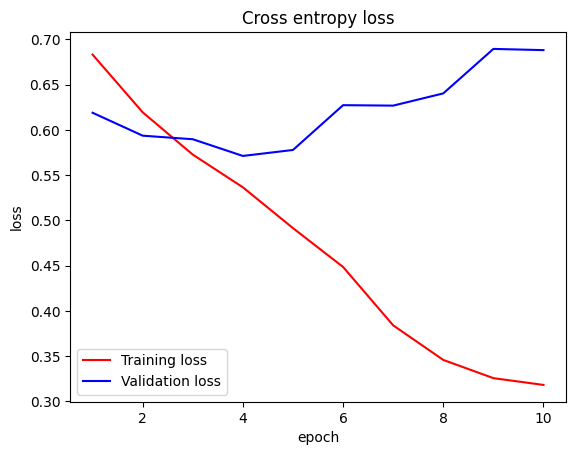

In [ ]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

def main(train_file,
         valid_file,
         embeddings_file,
         target_dir,
         hidden_size=300,
         dropout=0.5,
         num_classes=2,
         epochs=64,
         batch_size=32,
         lr=0.0004,
         patience=5,
         max_grad_norm=10.0,
         checkpoint=None):
    """
    Train the ESIM model on the SNLI dataset.

    Args:
        train_file: A path to some preprocessed data that must be used
            to train the model.
        valid_file: A path to some preprocessed data that must be used
            to validate the model.
        embeddings_file: A path to some preprocessed word embeddings that
            must be used to initialise the model.
        target_dir: The path to a directory where the trained model must
            be saved.
        hidden_size: The size of the hidden layers in the model. Defaults
            to 300.
        dropout: The dropout rate to use in the model. Defaults to 0.5.
        num_classes: The number of classes in the output of the model.
            Defaults to 3.
        epochs: The maximum number of epochs for training. Defaults to 64.
        batch_size: The size of the batches for training. Defaults to 32.
        lr: The learning rate for the optimizer. Defaults to 0.0004.
        patience: The patience to use for early stopping. Defaults to 5.
        checkpoint: A checkpoint from which to continue training. If None,
            training starts from scratch. Defaults to None.
    """
    device = torch.device("cpu" if torch.cuda.is_available() else "cpu")

    print(20 * "=", " Preparing for training ", 20 * "=")

    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    # -------------------- Data loading ------------------- #
    print("\t* Loading training data...")
    with open(train_file, "rb") as pkl:
        train_data = NLIDataset(pickle.load(pkl))

    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

    print("\t* Loading validation data...")
    with open(valid_file, "rb") as pkl:
        valid_data = NLIDataset(pickle.load(pkl))

    valid_loader = DataLoader(valid_data, shuffle=False, batch_size=batch_size)

    # -------------------- Model definition ------------------- #
    print("\t* Building model...")
    with open(embeddings_file, "rb") as pkl:
        embeddings = torch.tensor(pickle.load(pkl), dtype=torch.float)\
                     .to(device)

    model = ESIM(embeddings.shape[0],
                 embeddings.shape[1],
                 hidden_size,
                 embeddings=embeddings,
                 dropout=dropout,
                 num_classes=num_classes,
                 device=device).to(device)

    # -------------------- Preparation for training  ------------------- #
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                           mode="max",
                                                           factor=0.5,
                                                           patience=0)

    best_score = 0.0
    start_epoch = 1

    # Data for loss curves plot.
    epochs_count = []
    train_losses = []
    valid_losses = []

    # Continuing training from a checkpoint if one was given as argument.
    if checkpoint:
        checkpoint = torch.load(checkpoint)
        start_epoch = checkpoint["epoch"] + 1
        best_score = checkpoint["best_score"]

        print("\t* Training will continue on existing model from epoch {}..."
              .format(start_epoch))

        model.load_state_dict(checkpoint["model"])
        optimizer.load_state_dict(checkpoint["optimizer"])
        epochs_count = checkpoint["epochs_count"]
        train_losses = checkpoint["train_losses"]
        valid_losses = checkpoint["valid_losses"]

    # Compute loss and accuracy before starting (or resuming) training.
    _, valid_loss, valid_accuracy = validate(model,
                                             valid_loader,
                                             criterion)
    print("\t* Validation loss before training: {:.4f}, accuracy: {:.4f}%"
          .format(valid_loss, (valid_accuracy*100)))

    # -------------------- Training epochs ------------------- #
    print("\n",
          20 * "=",
          "Training ESIM model on device: {}".format(device),
          20 * "=")

    patience_counter = 0
    for epoch in range(start_epoch, epochs+1):
        epochs_count.append(epoch)

        print("* Training epoch {}:".format(epoch))
        epoch_time, epoch_loss, epoch_accuracy = train(model,
                                                       train_loader,
                                                       optimizer,
                                                       criterion,
                                                       epoch,
                                                       max_grad_norm)

        train_losses.append(epoch_loss)
        print("-> Training time: {:.4f}s, loss = {:.4f}, accuracy: {:.4f}%"
              .format(epoch_time, epoch_loss, (epoch_accuracy*100)))

        print("* Validation for epoch {}:".format(epoch))
        epoch_time, epoch_loss, epoch_accuracy = validate(model,
                                                          valid_loader,
                                                          criterion)

        valid_losses.append(epoch_loss)
        print("-> Valid. time: {:.4f}s, loss: {:.4f}, accuracy: {:.4f}%\n"
              .format(epoch_time, epoch_loss, (epoch_accuracy*100)))

        # Update the optimizer's learning rate with the scheduler.
        scheduler.step(epoch_accuracy)

        # Early stopping on validation accuracy.
        if epoch_accuracy < best_score:
            patience_counter += 1
        else:
            best_score = epoch_accuracy
            patience_counter = 0
            # Save the best model. The optimizer is not saved to avoid having
            # a checkpoint file that is too heavy to be shared. To resume
            # training from the best model, use the 'esim_*.pth.tar'
            # checkpoints instead.
            torch.save({"epoch": epoch,
                        "model": model.state_dict(),
                        "best_score": best_score,
                        "epochs_count": epochs_count,
                        "train_losses": train_losses,
                        "valid_losses": valid_losses},
                       os.path.join(target_dir, "best.pth.tar"))

        # Save the model at each epoch.
        torch.save({"epoch": epoch,
                    "model": model.state_dict(),
                    "best_score": best_score,
                    "optimizer": optimizer.state_dict(),
                    "epochs_count": epochs_count,
                    "train_losses": train_losses,
                    "valid_losses": valid_losses},
                   os.path.join(target_dir, "esim_{}.pth.tar".format(epoch)))

        if patience_counter >= patience:
            print("-> Early stopping: patience limit reached, stopping...")
            break

    # Plotting of the loss curves for the train and validation sets.
    plt.figure()
    plt.plot(epochs_count, train_losses, "-r")
    plt.plot(epochs_count, valid_losses, "-b")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend(["Training loss", "Validation loss"])
    plt.title("Cross entropy loss")
    plt.show()


main(config_training["train_data"],
      config_training["valid_data"],
      config_training["embeddings"],
      config_training["target_dir"],
      config_training["hidden_size"],
      config_training["dropout"],
      config_training["num_classes"],
      config_training["epochs"],
      config_training["batch_size"],
      config_training["lr"],
      config_training["patience"],
      config_training["max_gradient_norm"],

      )

# Evaluation

====================  Preparing for testing  ====================
	* Loading test data...
	* Building model...
====================  Testing ESIM model on device: cpu  ====================


<ipython-input-4-df67d084ddd8>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  sequences_lengths.new_tensor(torch.arange(0, len(sequences_lengths)))




-> Average batch processing time: 0.1314s, total test time: 28.1253s, accuracy: 69.5710%

Precision: 0.6963, Recall: 0.6963, F1-score: 0.6957


Confusion Matrix:
[[2332  927]
 [1123 2355]]


Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.72      0.69      3259
           1       0.72      0.68      0.70      3478

    accuracy                           0.70      6737
   macro avg       0.70      0.70      0.70      6737
weighted avg       0.70      0.70      0.70      6737



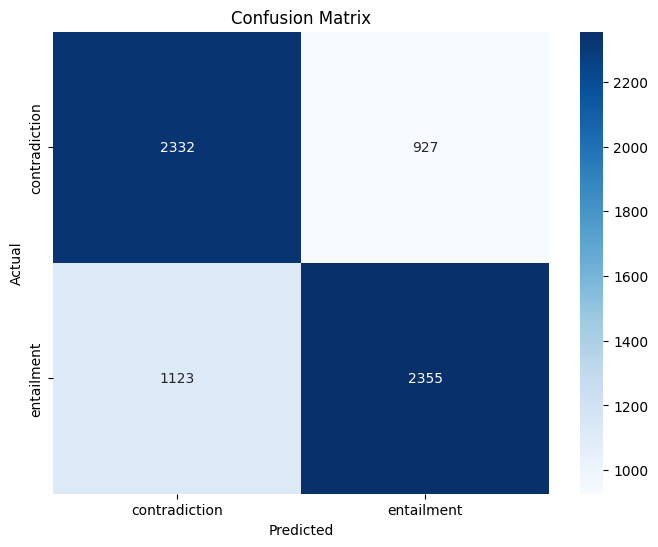

In [ ]:
import time
import pickle
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report
from torch.utils.data import DataLoader

# Function to calculate model accuracy
def correct_predictions(probs, labels):
    _, preds = torch.max(probs, 1)
    return torch.sum(preds == labels).item()

# Function to test the model and gather predictions and ground truth
def test(model, dataloader):
    """
    Test the accuracy of a model on some labelled test dataset.

    Args:
        model: The torch module on which testing must be performed.
        dataloader: A DataLoader object to iterate over some dataset.

    Returns:
        batch_time: The average time to predict the classes of a batch.
        total_time: The total time to process the whole dataset.
        accuracy: The accuracy of the model on the input data.
        predictions: The dictionary containing predictions and their corresponding true labels.
    """
    model.eval()  # Switch to eval mode
    device = model.device  # Get device from the model

    time_start = time.time()
    batch_time = 0.0
    accuracy = 0.0

    predictions = {}
    ground_truth = {}

    # Deactivate autograd for evaluation
    with torch.no_grad():
        for batch in dataloader:
            batch_start = time.time()

            # Move input and output data to the GPU if used
            premises = batch["premise"].to(device)
            premises_lengths = batch["premise_length"].to(device)
            hypotheses = batch["hypothesis"].to(device)
            hypotheses_lengths = batch["hypothesis_length"].to(device)
            labels = batch["label"].to(device)

            ids = batch["id"]

            _, probs = model(premises, premises_lengths, hypotheses, hypotheses_lengths)

            _, preds = torch.max(probs, 1)

            accuracy += correct_predictions(probs, labels)
            batch_time += time.time() - batch_start

            for i, pair_id in enumerate(ids):
                predictions[pair_id] = preds[i].item()
                ground_truth[pair_id] = labels[i].item()

    batch_time /= len(dataloader)
    total_time = time.time() - time_start
    accuracy /= len(dataloader.dataset)

    return batch_time, total_time, accuracy, predictions, ground_truth

# Function to evaluate and return confusion matrix
def evaluate(predictions, ground_truth):
    """
    Calculate Precision, Recall, F1-score, and Confusion Matrix.

    Args:
        predictions: Dictionary containing predicted class labels.
        ground_truth: Dictionary containing true class labels.

    Returns:
        precision, recall, f1-score, confusion matrix, and classification report.
    """
    pred_values = list(predictions.values())
    true_values = list(ground_truth.values())

    # Calculate precision, recall, F1-score, confusion matrix, and classification report
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_values, pred_values, average='macro'
    )

    confusion_mat = confusion_matrix(true_values, pred_values)
    class_report = classification_report(true_values, pred_values)

    return precision, recall, f1, confusion_mat, class_report

# Function to test the model, evaluate, and plot the confusion matrix
def main(test_file, pretrained_file, classes, batch_size=32):
    """
    Test the ESIM model with pretrained weights on some dataset.
    Plot confusion matrix after evaluation.

    Args:
        test_file: Path to a file containing preprocessed NLI data.
        pretrained_file: Path to a checkpoint with a pretrained model.
        classes: List of class names for the confusion matrix.
        batch_size: Size of the batches used for testing.
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    print(20 * "=", " Preparing for testing ", 20 * "=")

    checkpoint = torch.load(pretrained_file)  # Load the checkpoint

    vocab_size = checkpoint["model"]["_word_embedding.weight"].size(0)
    embedding_dim = checkpoint["model"]['_word_embedding.weight'].size(1)
    hidden_size = checkpoint["model"]["_projection.0.weight"].size(0)
    num_classes = checkpoint["model"]["_classification.4.weight"].size(0)

    # Load test data
    print("\t* Loading test data...")
    with open(test_file, "rb") as pkl:
        test_data = NLIDataset(pickle.load(pkl))

    test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

    # Build the model
    print("\t* Building model...")
    model = ESIM(vocab_size, embedding_dim, hidden_size, num_classes=num_classes, device=device).to(device)
    model.load_state_dict(checkpoint["model"])

    print(20 * "=", " Testing ESIM model on device: {} ".format(device), 20 * "=")

    # Test the model and gather predictions and ground truth
    batch_time, total_time, accuracy, predictions, ground_truth = test(model, test_loader)

    print("\n\n-> Average batch processing time: {:.4f}s, total test time: {:.4f}s, accuracy: {:.4f}%".format(
        batch_time, total_time, (accuracy * 100)
    ))

    # Evaluate and get confusion matrix
    precision, recall, f1, confusion_mat, class_report = evaluate(predictions, ground_truth)

    print(f"\nPrecision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")
    print("\n\nConfusion Matrix:")
    print(confusion_mat)
    print("\n\nClassification Report:")
    print(class_report)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

main("dev_data_preprocessed.pkl", "/content/drive/MyDrive/Colab Notebooks/best.pth.tar", ["contradiction", "entailment"], 32)  # Update test and pretrained file paths


In [ ]:
# import time
# import pickle
# import argparse
# import torch
# import csv

# from torch.utils.data import DataLoader

# def test(model, dataloader):
#     """
#     Test the accuracy of a model on some labelled test dataset.

#     Args:
#         model: The torch module on which testing must be performed.
#         dataloader: A DataLoader object to iterate over some dataset.

#     Returns:
#         batch_time: The average time to predict the classes of a batch.
#         total_time: The total time to process the whole dataset.
#         accuracy: The accuracy of the model on the input data.
#     """
#     # Switch the model to eval mode.
#     model.eval()
#     device = model.device

#     time_start = time.time()
#     batch_time = 0.0
#     accuracy = 0.0

#     predictions = {}

#     # Deactivate autograd for evaluation.
#     with torch.no_grad():
#         for batch in dataloader:
#             batch_start = time.time()

#             # Move input and output data to the GPU if one is used.
#             premises = batch["premise"].to(device)
#             premises_lengths = batch["premise_length"].to(device)
#             hypotheses = batch["hypothesis"].to(device)
#             hypotheses_lengths = batch["hypothesis_length"].to(device)
#             labels = batch["label"].to(device)

#             ids = batch["id"]

#             _, probs = model(premises,
#                              premises_lengths,
#                              hypotheses,
#                              hypotheses_lengths)

#             _, preds = torch.max(probs, 1)

#             accuracy += correct_predictions(probs, labels)
#             batch_time += time.time() - batch_start

#             for i, pair_id in enumerate(ids):
#                 predictions[pair_id] = preds[i].item()


#     batch_time /= len(dataloader)
#     total_time = time.time() - time_start
#     accuracy /= (len(dataloader.dataset))

#     with open("results.csv", 'w', newline='') as file:
#         writer = csv.writer(file)
#         writer.writerow(['Prediction'])  # Writing header
#         for pair_id, pred in predictions.items():
#             writer.writerow([pred])

#     return batch_time, total_time, accuracy


# def main(test_file, pretrained_file, batch_size=32):
#     """
#     Test the ESIM model with pretrained weights on some dataset.

#     Args:
#         test_file: The path to a file containing preprocessed NLI data.
#         pretrained_file: The path to a checkpoint produced by the
#             'train_model' script.
#         vocab_size: The number of words in the vocabulary of the model
#             being tested.
#         embedding_dim: The size of the embeddings in the model.
#         hidden_size: The size of the hidden layers in the model. Must match
#             the size used during training. Defaults to 300.
#         num_classes: The number of classes in the output of the model. Must
#             match the value used during training. Defaults to 3.
#         batch_size: The size of the batches used for testing. Defaults to 32.
#     """
#     device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#     print(20 * "=", " Preparing for testing ", 20 * "=")

#     checkpoint = torch.load(pretrained_file)

#     # Retrieving model parameters from checkpoint.
#     vocab_size = checkpoint["model"]["_word_embedding.weight"].size(0)
#     embedding_dim = checkpoint["model"]['_word_embedding.weight'].size(1)
#     hidden_size = checkpoint["model"]["_projection.0.weight"].size(0)
#     num_classes = checkpoint["model"]["_classification.4.weight"].size(0)

#     print("\t* Loading test data...")
#     with open(test_file, "rb") as pkl:
#         test_data = NLIDataset(pickle.load(pkl))

#     test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

#     print("\t* Building model...")
#     model = ESIM(vocab_size,
#                  embedding_dim,
#                  hidden_size,
#                  num_classes=num_classes,
#                  device=device).to(device)

#     model.load_state_dict(checkpoint["model"])

#     print(20 * "=",
#           " Testing ESIM model on device: {} ".format(device),
#           20 * "=")
#     batch_time, total_time, accuracy = test(model, test_loader)

#     print("-> Average batch processing time: {:.4f}s, total test time:\
#  {:.4f}s, accuracy: {:.4f}%".format(batch_time, total_time, (accuracy*100)))

# main("/content/SNLI/dev_data.pkl", "/content/SNLITrain/best.pth.tar", 32) #checkpoint: Path to a checkpoint with a pretrained model

====================  Preparing for testing  ====================
	* Loading test data...
	* Building model...
====================  Testing ESIM model on device: cpu  ====================


<ipython-input-4-df67d084ddd8>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  sequences_lengths.new_tensor(torch.arange(0, len(sequences_lengths)))


-> Average batch processing time: 0.1361s, total test time: 28.9428s, accuracy: 69.5710%
